# <span style="color:blue">  Laboratorio 10 - Parallel computation</span>

In [1]:
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np

## Exercise 10.1
All' interno del laboratorio è stata svolta la **parallelizzazione** dell'*algoritmo genetico* sviluppato nel [Laboratorio 9](https://github.com/ChiaraBallotta/LSN_Ballotta_Chiara/blob/master/Laboratorio9/Ex-9.ipynb).

La parallelizzazione è stata svolta mediante l'utilizzo delle librerie **MPI**. Viene utilizzato il modello **SPMD** (Single Program Multiple Data), in cui tutti i nodi eseguono lo stesso programma. 

E' stata inoltre implementata la possibilità che, ogni $N_{migr}$ generazioni, il migliore individuo di ciascun nodo esegua una **migrazione** verso un altro nodo; ovvero che avvenga uno scambio di informazioni tra nodi. Più avanti sarà spiegato come è stata implementata nel dettaglio la migrazione.

**Osservazione**: il numero di noodi/core che si vogliono utilizzare è scelto nel  ` makefile ` . Durante il laboratorio sono sempre stati utilizzati **4 Nodi**.

### Funzionamento del codice

Chiamo *Continente* , l'ottimizzazione indipendente svolta da ciascun nodo mediante *GA*.
In ciascun *Continente* il processo di ottimizzazione avviene in maniera analoga a come descritto nel [Laboratorio 9](https://github.com/ChiaraBallotta/LSN_Ballotta_Chiara/blob/master/Laboratorio9/Ex-9.ipynb).

***Osservazione***: ciascun nodo parte dallo stesso problema, ovvero ciascun nodo riceve la stessa disposizione delle città nell'array( uguali *cordinate*, uguale *label*) e la stessa *popolazione iniziale* **MA** voglio che i nodi operino su una statistica differente( altrimenti ciascun nodo otterrebbe lo stesso risultato)$\rightarrow$ la classe  `Random ` viene inizializzata in modo differente a seconda del nodo che la sta richiamando: la scelta dei seed è differente. Questo processo assicura che ciascun nodo realizzi un'ottimazione **indipedendente**. 

Durante il *Laboratorio 10* è stata implementata la possibilità che avvenga una **migrazione** del migliore individuo, tra un nodo e l'altro.L'*individuo* da scambiare è stato scelto mediante una legge di potenza ( analoga a quella utilizzata in  `main.cpp/selez() `) : 

$$ J = int(M x r_p) + 1$$

dove $M$ *= numero degli Individui* e $p = 20$. Inizialmente il valore era stato fissato a $p= 15$ ma ho deciso di aumentarlo per spingere maggiormente la scelta degli individui migliori. Ho scelto di far si che la scelta dell' individuo che migrerà segua una legge di potenza perchè mi sembrava una soluzione ergodicamente migliore rispetto  a scambiare ogni volta l' individuo con la *Loss* più piccola ( il *migliore).

Sintetizzo i punti chiave che compongo la **migrazione**:
1. Ho definito la variabile  `N_migraz `, la quale indica il numero di mutazioni che si interpongono a ogni migrazione. Per il calcolo finale del numero di Generazioni, una migrazione è da intendersi come una mutazione per il nodo ricevente.
2. Dopo aver eseguito $N_{migraz}$ ciascun nodo si ferma in attesa che anche gli altri finiscano le migrazioni. Questo processo è stato implementato mediante  `MPI_Barrier(MPI_COMM_WORLD) `.
3. Il nodo $0$ seleziona quindi il **sender**,il **receiver** e la posizione dell' **individuo** che sarà migrato; gli altri nodi rimangono in *stand-by*.
4. I nodi non coinvolti dalla migrazione, e il *sender*, eseguono un ulteriore mutazione mentre il *receiver* salva al posto del peggior individuo, il *nuovo individuo* inviatogli  dal *sender*.


***Osservazione*** : Ho deciso di non implementare comuncazione *Bilaterale* per evitare di avere problemi con il *buffer*. Inoltre ho utilizzato la funzione `MPI_Barrier(MPI_COMM_WORLD) ` per assicurarmi che tutti i nodi proseguano **esattamente** in parallelo e in maniera sincrona; questa scelta è stata fatta per eliminare possibili problemi con i *buffer* durante la fase di *migrazione.


## Exercise 10.2
Il codice è stato utilizzato per risolvere il probelma del commesso viaggiatore attraverso le 50 capitali USA. 

Di seguito è stato svolto un paragone tra i risultati ottenuti mediante:
1. 1 nodo solamente
2. Parallelizzazione senza Migrazione
3. Parallelizzazione con Migrazione

In tutti i casi, i parametri utilizzati sono i seguenti: `N_generaz`$=500$ e `N_individui` $= 1000$ e $=3000$.

### Organizzazione file di Output
A seconda del numero di individui,sono state generate due cartelle distinte: `Ex-10/1000 ` e  `Ex-10/3000 `. In ciascuna cartella, sono contenuti i risultati ottenuti mediante le varie casistiche. I rispettivi identificativi sono:
-  `1 `: 1 Solo nodo
-  `2 `: Parallelizzazione senza migrazione
-  `3 `: Parallelizzazione con migrazione
Nelle cartelle  `2 ` e `3 `, ciascun nodo genera una serie di file analoghi a quelli decsritti nel [Laboratorio 9](https://github.com/ChiaraBallotta/LSN_Ballotta_Chiara/blob/master/Laboratorio9/Ex-9.ipynb); dal nome del file è possibile identificare il nodo che l' ha generato: *es* `2_best.dat` $\rightarrow$ file `best.dat` generato dal * secondo nodo*.


#### 0. Campionamento delle capitali USA

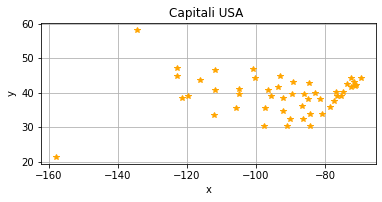

In [2]:
x,y= np.loadtxt("Ex-10/American_capitals.dat", usecols = (0,1), delimiter = None, unpack = 'true')
plt.plot(x,y,marker = '*',color = 'orange',linestyle = 'none')
plt.xlabel('x')
plt.ylabel('y')
plt.title("Capitali USA ")
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True) 
plt.show()

### 2. Parallelizzazione senza migrazione

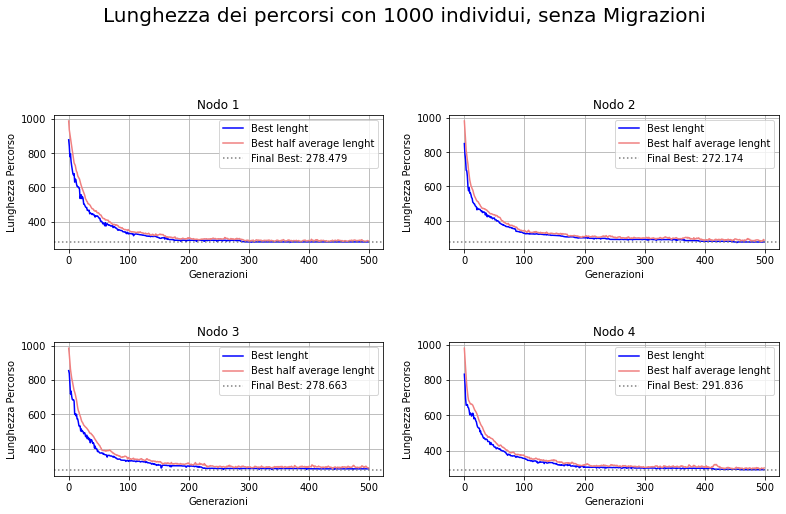

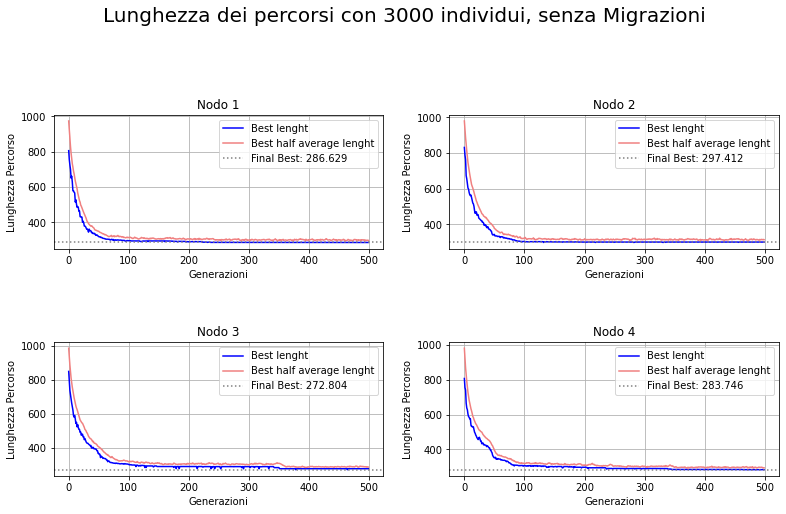

In [3]:
# salvo le citta, cordinate e label, su degli array
n_cities = 50
individui= ["1000","3000"]
rank =["0", "1", "2","3"]
nodi = ["1", "2", "3","4"]
for l in range(0,2):
    plt.figure(figsize=(13,15))
    plt.suptitle('Lunghezza dei percorsi con '+individui[l]+' individui, senza Migrazioni',fontsize = 20) 

    for i in range(0,4):
        plt.subplot(4,2,i+1)
        generazioni,lenght_ave = np.loadtxt("Ex-10/"+individui[l]+"/2/"+rank[i]+"_best_ave.dat",usecols = (0,1),delimiter = " ",unpack = 'true')
        lenght = np.loadtxt("Ex-10/"+individui[l]+"/2/"+rank[i]+"_best.dat",usecols = (0),delimiter = " ",unpack = 'true')
        plt.plot(generazioni,lenght,label = 'Best lenght',color = 'blue')
        plt.plot(generazioni,lenght_ave,label = 'Best half average lenght',color = 'lightcoral')

        best_best =np.loadtxt("Ex-10/"+individui[l]+"/2/"+rank[i]+"_Best_best.dat",delimiter = None, unpack = 'true') 
        plt.axhline(y=best_best[0], color = 'gray', linestyle = 'dotted', label = "Final Best: "+str(best_best[0])) 
        plt.xlabel('Generazioni')
        plt.ylabel('Lunghezza Percorso')
        plt.legend()
        plt.grid()
        plt.title('Nodo '+nodi[i])



    plt.subplots_adjust(hspace=0.7)
    plt.show()

Noto che, un maggior numero di individui permette all' algortimo di convegere più velocemente, almeno nella fase iniziale. Ciononostante questo non permette di raggiungere risultati migliori al termine dell'ottimizzazione. Questa cosa è rispecchiata anche nello studio della sequenza di città visitate.

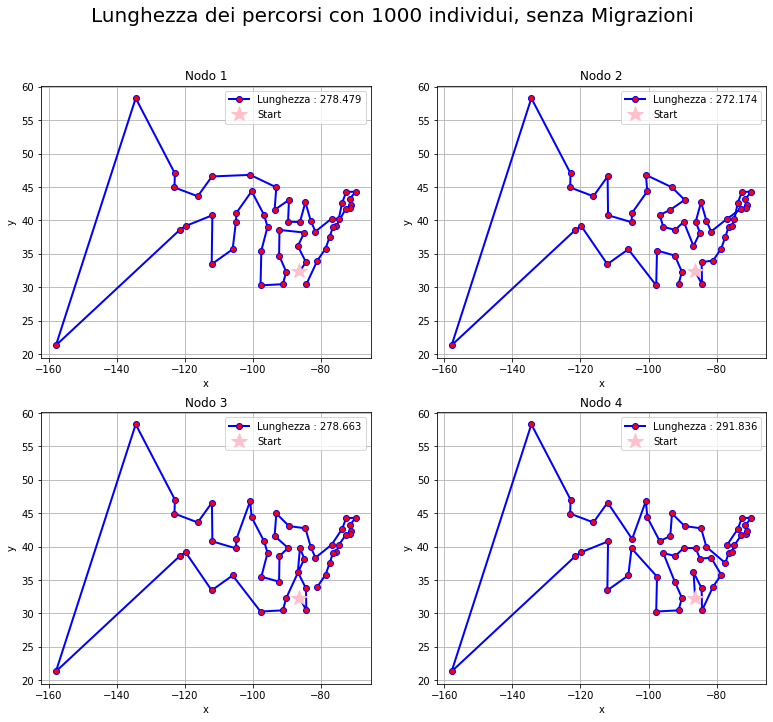

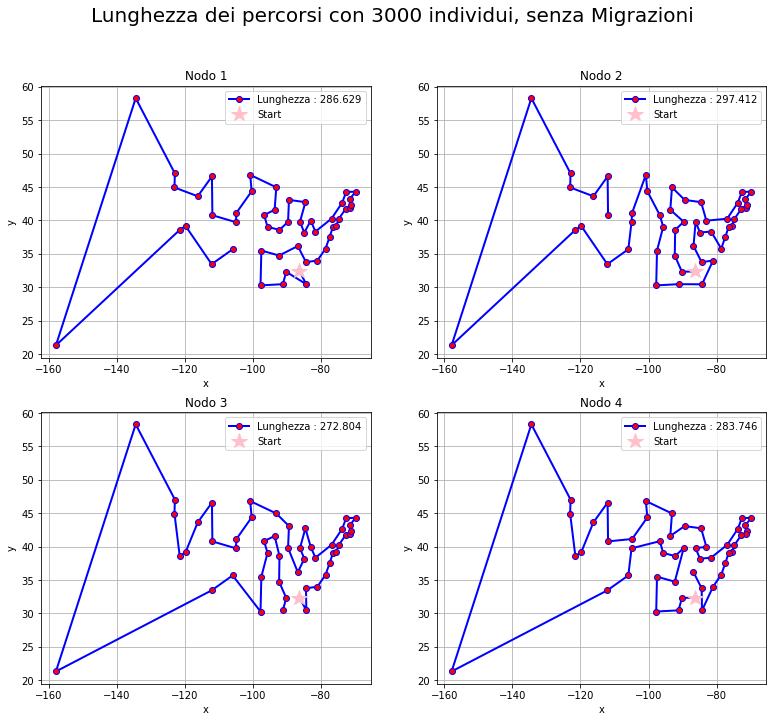

In [5]:
N_generazioni = 500
N_cities = 50
individui= ["1000","3000"]
rank =["0", "1", "2","3"]
nodi = ["1", "2", "3","4"]
for l in range(0,2) : 
    plt.figure(figsize=(13,11))
    plt.suptitle('Lunghezza dei percorsi con '+individui[l]+' individui, senza Migrazioni',fontsize = 20) 

    for i in range(0,4):
        plt.subplot(2,2,i+1)
        best_best =np.loadtxt("Ex-10/"+individui[l]+"/2/"+rank[i]+"_Best_best.dat",delimiter = None, unpack = 'true') 
        x_best = np.zeros(N_cities)
        y_best= np.zeros(N_cities)
        contatore = 0
        lunghezza= best_best[0]
        for j in range(0,50,1):
            contatore = int(best_best[j+1])
            x_best[j] = x[contatore-1]
            y_best[j] = y[contatore-1]    
        plt.plot(x_best,y_best,marker = 'o',markerfacecolor = 'red',color = 'blue',label='Lunghezza : '+str(lunghezza),linewidth=2)  
        plt.plot(x_best[0],y_best[0], marker ="*", color = "pink", markersize = 16, label = "Start", linestyle = "")
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title("Nodo "+nodi[i])
        plt.grid(True) 
        plt.legend()



    plt.show()

### 3. Parallelizzazione con migrazione
Inizialmente avevo fissato $p = 15$ ma, siccome mi sono accorta che la convergenza dell' algortimo non era ottima, ho deciso di provare a alzare il valore a $p=20$ (Analizzando i valori $j$ estratti mediante la legge di potenza ho decretato che fosse inutile alzare ulteriormente il valore).

Nel passaggio da $p = 15 \rightarrow p = 20$ ho potuto notare che l' algoritmo ottimizza meglio il problema: la lunghezza del percorso svolto è diminuita.

All'interno della cartella `Ex-10/1000` sono comunque stati salvati entrambi o risultati, suddivisi nelle rispettive cartelle :`3_p=15` e `3_p=20`.

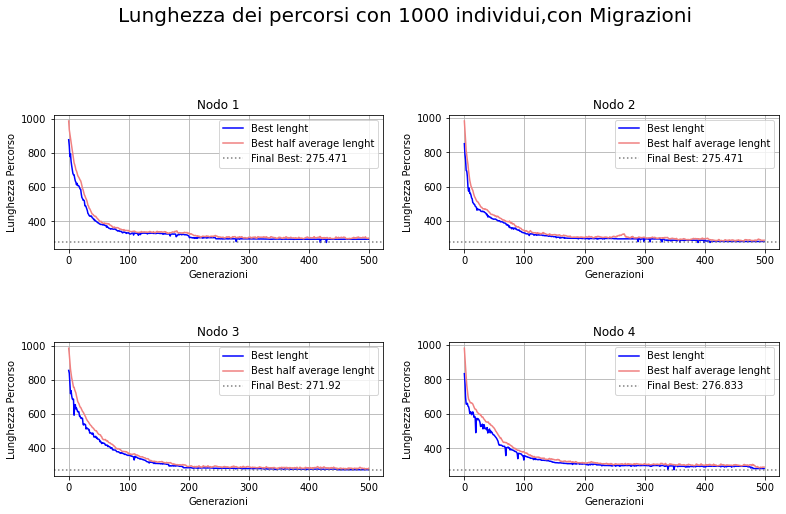

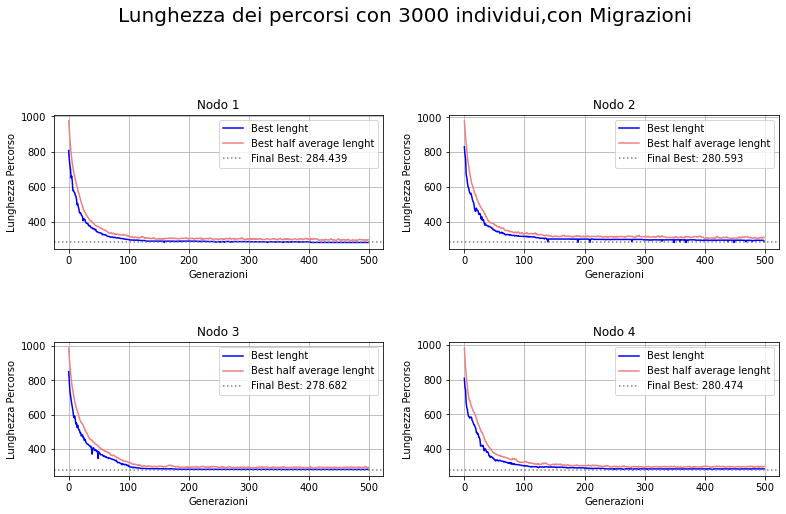

In [6]:
# salvo le citta, cordinate e label, su degli array
n_cities = 50
individui = ["1000","3000"]

p = ["3_p=15","3_p=20"]

rank =["0", "1", "2","3"]
nodi = ["1", "2", "3","4"]
for l in range(0,2) : 
    plt.figure(figsize=(13,15))
    plt.suptitle('Lunghezza dei percorsi con '+individui[l]+' individui,con Migrazioni',fontsize = 20) 

    for i in range(0,4):
        plt.subplot(4,2,i+1)
        generazioni,lenght_ave = np.loadtxt("Ex-10/"+individui[l]+"/"+p[1]+"/"+rank[i]+"_best_ave.dat",usecols = (0,1),delimiter = " ",unpack = 'true')
        lenght = np.loadtxt("Ex-10/"+individui[l]+"/"+p[1]+"/"+rank[i]+"_best.dat",usecols = (0),delimiter = " ",unpack = 'true')
        plt.plot(generazioni,lenght,label = 'Best lenght',color = 'blue')
        plt.plot(generazioni,lenght_ave,label = 'Best half average lenght',color = 'lightcoral')

        best_best =np.loadtxt("Ex-10/"+individui[l]+"/"+p[1]+"/"+rank[i]+"_Best_best.dat",delimiter = None, unpack = 'true') 
        plt.axhline(y=best_best[0], color = 'gray', linestyle = 'dotted', label = "Final Best: "+str(best_best[0])) 
        plt.xlabel('Generazioni')
        plt.ylabel('Lunghezza Percorso')
        plt.legend()
        plt.grid()
        plt.title('Nodo '+nodi[i])



    plt.subplots_adjust(hspace=0.7)
    plt.show()

La *migrazione* assicura una migliore convergenza dell' algortimo. Le osservazioni che sono state svolte nella *sezione 1* riguardanti il numero di inividui persistono.

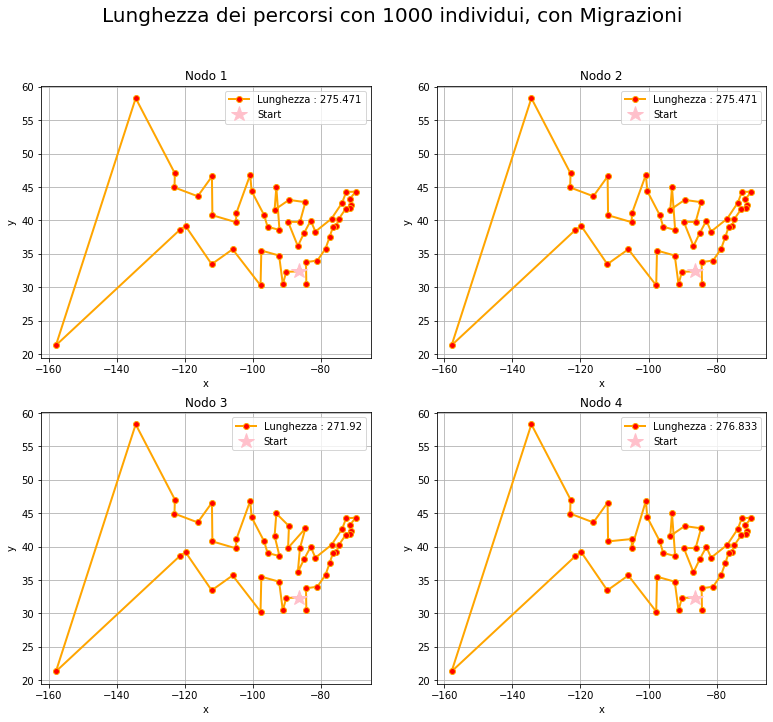

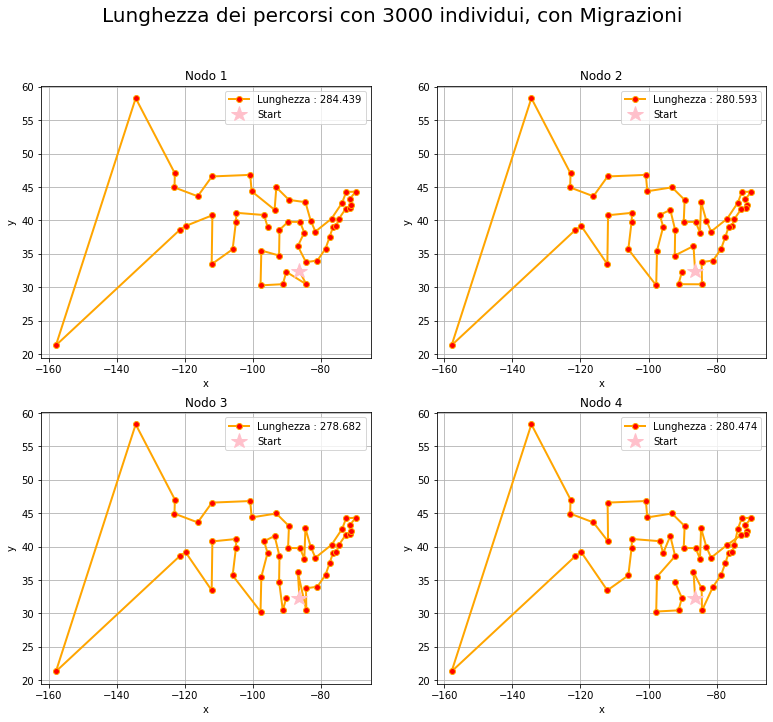

In [7]:
N_generazioni = 500
N_cities = 50
rank =["0", "1", "2","3"]
nodi = ["1", "2", "3","4"]

for l in range(0,2) : 
    plt.figure(figsize=(13,11))
    plt.suptitle('Lunghezza dei percorsi con '+individui[l]+' individui, con Migrazioni',fontsize = 20) 

    for i in range(0,4):
        plt.subplot(2,2,i+1)
        best_best =np.loadtxt("Ex-10/"+individui[l]+'/'+p[1]+"/"+rank[i]+"_Best_best.dat",delimiter = None, unpack = 'true') 
        x_best = np.zeros(N_cities)
        y_best= np.zeros(N_cities)
        contatore = 0
        lunghezza= best_best[0]
        for j in range(0,50,1):
            contatore = int(best_best[j+1])
            x_best[j] = x[contatore-1]
            y_best[j] = y[contatore-1]    
        plt.plot(x_best,y_best,marker = 'o',markerfacecolor = 'red',color = 'orange',label='Lunghezza : '+str(lunghezza),linewidth=2)  
        plt.plot(x_best[0],y_best[0], marker ="*", color = "pink", markersize = 16, label = "Start", linestyle = "")
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title("Nodo "+nodi[i])
        plt.grid(True) 
        plt.legend()



    plt.show()

### 1. 1 nodo solamente

Ometto i grafici i quanto sarebbero esatamente gli stessi( per come è stato costruito il programma) presenti nel **caso 1, nodo 1**.

### Conclusione
La ***migliore ottimizzazione***, ovvero il percorso più breve che collega le 50 capitali degli Stati Uniti d'America, è la seguente:
![](best_path.jpg)
ottenuta dal *Nodo 3* durante il processo di **parallelizzazionne con migrazione** con **1000 individui** per popolazione.